## CONSTRUCTION D'UN MODÈLE DE MACHINE LEARNING POUR PRÉDIRE LE DESABONNEMENT DES CLIENTS D'UNE ENTREPRISE

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
import joblib

In [124]:
#lien dataset

#https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download

In [125]:
# Importation des données

df = pd.read_csv("/Users/abbasmzehamadi/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


La variable cible est la variable Churn qui prend deux valeurs : Yes (le client s'est désabonné) et No (le client ne s'est pas désabonné)

In [126]:
# Informations sur l'ensemble des données

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [127]:
# Nombres de valeurs uniques par colonnes

df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

## Analyse exploratoire des données

In [128]:
# Variables catégorielles

categorical_columns = df.nunique()[df.nunique() < 5].keys().to_list()

categorical_columns


['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [129]:
# Création d'une fonction de construction de graphiques à barres

def bar_plot(a):
    df[a].value_counts(normalize = True).plot(kind = 'bar')
    plt.ylabel('proportion')
    plt.title(f'Distribution of {a}')
    return plt.show()

In [130]:
# Interact

interact(bar_plot, a = categorical_columns)

interactive(children=(Dropdown(description='a', options=('gender', 'SeniorCitizen', 'Partner', 'Dependents', '…

<function __main__.bar_plot(a)>

- ***il y a plus de clients qui ne sont pas désabonnées (plus de 70%) que de clients qui se sont désabonné (moins de 30%).*** Donc nous avons un problème de déséquilibre qu'il faudra absolument résoudre car ça peut impacter négativement la performance des modèles de classification que nous allons construire

- ***La distribution des données entre les différents sexes est à pe près également répartie.***

- ***Le nombre de clients qui sont des personnes âgées (moins de 20%) est bien inférieur à celui des clients jeunes (plus de 80%).***

- ***La variable Partner indique si le client a un partenaire (Yes) ou pas (No). Les deux catégories ont pratiquement la même proportion.***

In [131]:
# Echantillonnement aléatoire de la variable 'TotalCharges'

df['TotalCharges'].sample(10)

4465     1523.4
924      1820.9
6863    2985.25
5268     6194.1
2695    4354.45
2549       33.7
2102    1406.65
4053     662.95
1802        280
5146      893.2
Name: TotalCharges, dtype: object

On voit que par la cause de la présence d'espace au nniveau de variables **TotalCharges**, Pandas va la considèrer comme étant une variable avec des valeurs de type object (chaîne de caractère).

Donc on va remplacer ces espaces par des NaN (Not a Number) et transformer le type de ces valeurs en float (décimal).

In [132]:
# variables quantitatives

numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [133]:
# Création d'une fonction de construction d'histogrammes et de manière interactive

def hist_plot(b):
    sns.distplot(df[b], kde=False)
    plt.title(f'Histogram of {b}')
    return plt.show()


# Conversion du type des valeurs de la variable 'TotalCharges' en floeat (décimal)

df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)

In [134]:
#Interact

interact(hist_plot, b = numerical_columns)

interactive(children=(Dropdown(description='b', options=('tenure', 'MonthlyCharges', 'TotalCharges'), value='t…

<function __main__.hist_plot(b)>

In [135]:
# Coefficient d'asyémtrie de la variable 'TotalCharges'

df['TotalCharges'].skew()

0.961642499724251

In [136]:
# Création d'une fonction de construction de boites à moustaches et de manière interactive

def box_plot(b):
    sns.boxplot(y = df[b])
    plt.title(f'Boxplot of {b}')
    return plt.show()



In [137]:
# interact

interact(box_plot, b = numerical_columns)

interactive(children=(Dropdown(description='b', options=('tenure', 'MonthlyCharges', 'TotalCharges'), value='t…

<function __main__.box_plot(b)>

Nous pouvons remarquer que ces variables continues bien que ne présentant pas de valeurs aberrantes (outliers) sont très asymétriques ce qui peut causer des erreurs au niveau des modèles que nous allons construire.

Nous pouvons appliquer des fonctions de transformation à ces variables afin de les rendre moins asymétriques

Après avoir réalisé une analyse univariée, passons à l’analyse bivariée.

## analyse bivariées

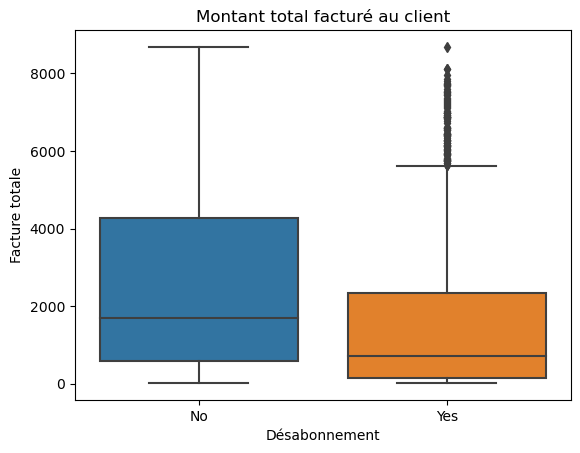

In [138]:
# TotalCharges vs Churn

sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.xlabel('Désabonnement')
plt.ylabel('Facture totale')
plt.title('Montant total facturé au client')
plt.show()

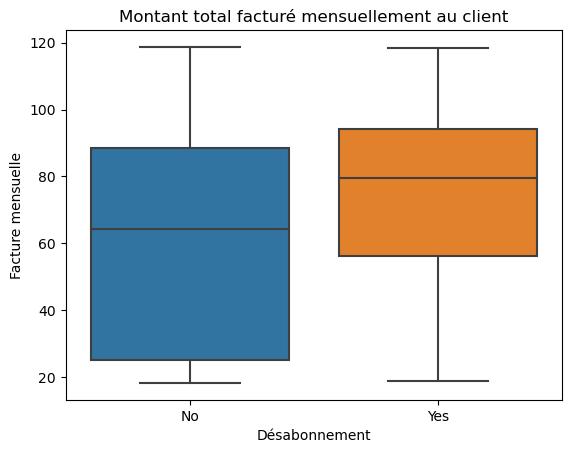

In [139]:
# MonthlyCharges vs Churn


sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.xlabel('Désabonnement')
plt.ylabel('Facture mensuelle')
plt.title('Montant total facturé mensuellement au client')
plt.show()

Le montant total facturé aux clients qui ont résilié leur contrat est inférieurs au montant total facturé aux clients qui ne l'ont pas fait. ***Mais, les clients qui se sont désabonnés sont plus facturés mensuellement que les clients qui se sont pas désabonnés.*** Cette information est très importante pour l'entreprise car le montant facturé mensuellement peut être un facteur important qui détermine si un client va s désabonner ou non.


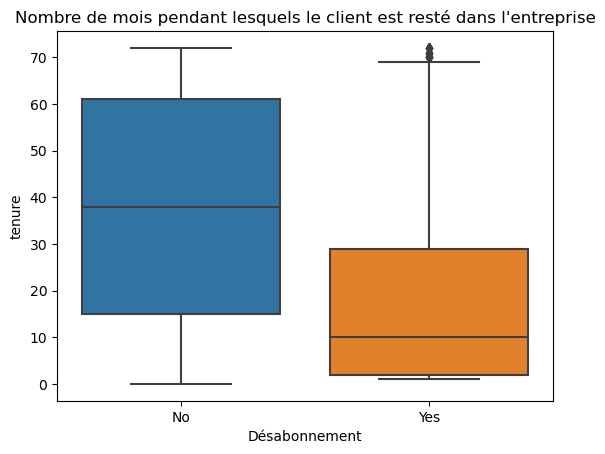

In [140]:
# tenure vs Churn


sns.boxplot(x='Churn', y='tenure', data=df)
plt.xlabel('Désabonnement')
plt.title("Nombre de mois pendant lesquels le client est resté dans l'entreprise")
plt.show()

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

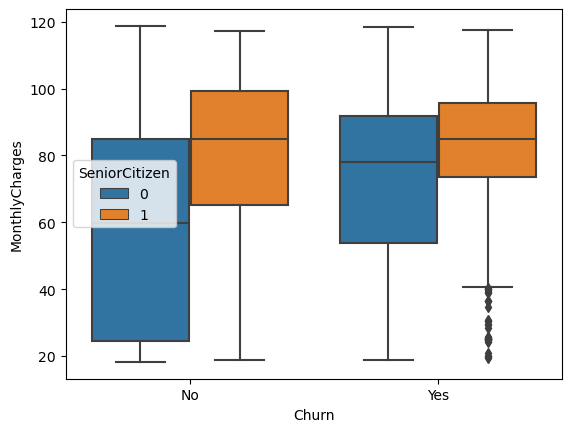

In [141]:
# Monthly vs Churn by SeniorCitizen

sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data=df, hue = 'SeniorCitizen')

Il semble que les personnes âgées soient beaucoup plus facturées mensuellement que les jeunes. Malgré cela, ils restent plus fidèles à l'entreprise que les jeunes.

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

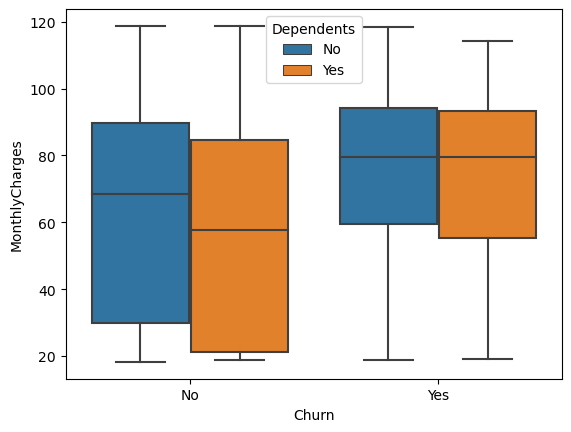

In [142]:
# MonthlyCharges vs Churn by Dependents


sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data=df, hue = 'Dependents')


In [143]:
# Résumé statistique

df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


Comme vous pouvez le voir, les trois variables quantitatives (**tenure, MonthlyCharges et TotalCharges**) ont différentes échelles. **tenure** varie entre 0 et 72 tandis que **MonthlyCharges** varie entre 18.25 et 118.75 et **TotalCharges** varie entre 18.8 et 8684.8. De nombreux modèles de Machine et de Deep Learning fonctionnent mieux avec des variables standardisées ou normalisées.

Nous allons alors standardisé les données dans la section de prétraitement des données.

# Prétraitement des données

In [144]:
# Gestion des valeurs manquantes

data = df.copy()

data.isna().sum()


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [145]:
# Suppression des valeurs manquantes


data.dropna(inplace=True)

data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [146]:
# Encodage des variables catégorielles restantes

data['gender'] = data['gender'].apply(lambda row: 1 if row == 'Female' else 0)

binary_columns = data.drop('gender', axis=1).nunique()[data.drop('gender', axis=1).nunique() < 3].keys().to_list()

binary_columns

['SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [147]:
for column in binary_columns:
    data[column] = data[column].apply(lambda row: 1 if row == 'Yes' else 0)

In [148]:
# Encodage des variables catégorielles restantes


remaining_cat_vars = data[categorical_columns].nunique()[data[categorical_columns].nunique() > 2].keys().to_list()

remaining_cat_vars

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [149]:
remaining_cat_vars_dummies = pd.get_dummies(data=data[remaining_cat_vars], columns=remaining_cat_vars, drop_first=True).astype(int)

In [150]:
# Nouvelle dataframe

data = pd.concat([data['gender'], data[binary_columns], remaining_cat_vars_dummies, data[numerical_columns]], axis=1)

In [151]:
# Affichage de la nouvelle dataframe

data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,1,29.85,29.85
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,34,56.95,1889.50
2,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,1,2,53.85,108.15
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,45,42.30,1840.75
4,1,0,0,0,1,1,1,0,0,1,...,0,0,0,0,0,1,0,2,70.70,151.65


In [152]:
# Shape de data

data.shape

(7032, 31)

on sait que la variable TotalCharges est très asymétrique alors transformons-là par une racine carrée.

/Users/abbasmzehamadi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/abbasmzehamadi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


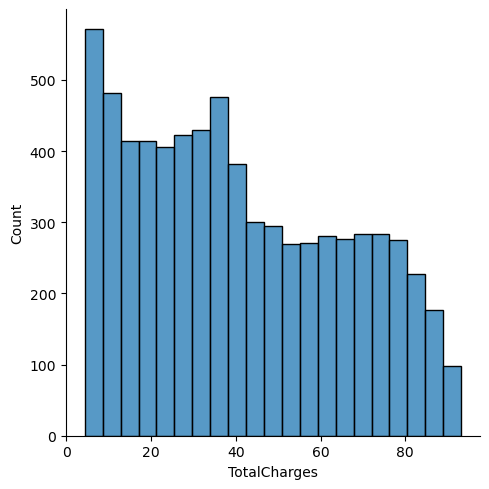

In [153]:
# Transformation de la variable 'TotalCharges'

data['TotalCharges'] = np.sqrt(data['TotalCharges'])


# Histogramme de la variable transformée

sns.displot(data['TotalCharges'], kde=False)

In [154]:
# Coefficient d'asymétrie de la variable 'TotalCharges' après transformation

data['TotalCharges'].skew()

0.3089261418986736

**Nous divisons ici les données en trois ensembles :**

**Les données d’entraînement servent à entraîner les modèles.**

**Les données de validation** permettent de **sélectionner le meilleur** modèle parmi plusieurs algorithmes testés. Chaque algorithme est entraîné sur les données d’entraînement, puis évalué sur les données de validation. Cela permet d’identifier le modèle qui offre les meilleures performances sur des données qu’il n’a jamais vues.

**Les données de test** servent à **évaluer une dernière fois** le modèle sélectionné, afin de **vérifier sa capacité à généraliser** sur de nouvelles données.
C’est une étape de **vérification finale**, indépendante de tout le processus de sélection.



In [155]:
# Données d'entraînement (60%), de validation (20%) et de test (20%)

X = data.drop('Churn', axis = 1)

y = data['Churn']

seed = 1111


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = seed, stratify = y)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = seed, stratify = y_test)

Le paramètre **stratify = y** permet de s'assurer que les proportions de personnes ayant resilié ou non leur contrat soient les mêmes dans les différents ensembles de données.

En effet, nous sommes ici confrontés à un problème de déséquilibre de classes.
L’analyse exploratoire des données a révélé qu’il y a beaucoup plus de clients qui ne se sont pas désabonnés que de clients ayant résilié leur contrat.

Dans ce contexte, il est essentiel de veiller à ce que la répartition des classes soit préservée lors de la division du jeu de données en ensembles (entraînement, validation, test).
En d’autres termes, la proportion de clients ayant résilié ou non leur contrat doit rester similaire dans chacun de ces ensembles.

Si cette condition n’est pas respectée, cela peut introduire un biais dans la modélisation et nuire à la capacité du modèle à bien généraliser, notamment pour la classe minoritaire.

In [156]:
# Fréquence des classes dans y

pd.DataFrame(y).value_counts(normalize = True)

Churn
0        0.734215
1        0.265785
Name: proportion, dtype: float64

In [157]:
# Fréquence des classes dans y_train

pd.DataFrame(y_train).value_counts(normalize = True)

Churn
0        0.734297
1        0.265703
Name: proportion, dtype: float64

In [158]:
# Fréquence des classes dans y_val

pd.DataFrame(y_val).value_counts(normalize = True)

Churn
0        0.733997
1        0.266003
Name: proportion, dtype: float64

In [159]:
# Fréquence des classes dans y_test

pd.DataFrame(y_test).value_counts(normalize = True)

Churn
0        0.734186
1        0.265814
Name: proportion, dtype: float64

## Traitement du déséquilibre de classe

Nous allons maintenant aborder le problème de déséquilibre de classe présent dans nos données.

Lorsque la variable cible à prédire présente une répartition très inégale entre ses différentes catégories, cela peut fortement biaiser l’apprentissage du modèle. En effet, ce dernier pourrait avoir tendance à privilégier la classe majoritaire, au détriment de la classe minoritaire, ce qui dégrade les performances globales — en particulier sur les observations les plus rares.

Dans notre cas, environ 73 % des clients n’ont **pas résilié** leur abonnement, contre seulement 26 % qui l’ont **résilié**. Ce déséquilibre important nécessite une correction.

Pour cela, nous pouvons utiliser des techniques de **rééchantillonnage** visant à rééquilibrer les classes :

soit en **suréchantillonnant** la classe minoritaire (en générant artificiellement davantage d’observations pour cette classe),

soit en **sous-échantillonnant** la classe majoritaire (en réduisant le nombre d’observations de cette classe dans l’ensemble d’apprentissage).

In [160]:
# Réslution du problème de déséquilibre de classe : Méthode de sur-echantillonnage de la classe minoritaire

X2 = X_train

X2['Churn'] =  y_train.values

minority = X2[X2.Churn == 1]


majority = X2[X2.Churn == 0]

minority_upsampled = resample(minority, replace = True, n_samples = len(majority), random_state=seed)

upsampled = pd.concat([majority, minority_upsampled])

upsampled

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn
6406,1,0,0,0,0,1,1,0,0,0,...,1,0,0,1,0,0,39,50.65,43.650888,0
6124,1,0,1,1,1,1,0,0,0,0,...,0,1,0,0,0,1,57,59.30,57.221936,0
4051,1,0,1,0,1,1,0,1,1,0,...,1,0,1,1,0,0,72,97.70,82.883653,0
3839,1,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,1,15,20.05,16.861198,0
2523,1,0,1,1,1,0,0,0,0,1,...,0,0,1,1,0,0,47,20.25,29.553342,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,1,0,0,1,1,1,0,0,1,0,...,0,0,0,0,1,0,1,69.65,8.345658,1
6040,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,70.75,8.411302,1
4212,1,0,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,1,90.60,9.518403,1
508,1,0,1,1,1,1,0,1,1,0,...,0,0,0,0,1,0,6,80.50,22.424317,1


In [161]:
# Vérification

upsampled['Churn'].value_counts(normalize = True)

Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

In [162]:
# Données d'entrainement sur la base de la méthode de sur-echantillonnage de la classe minoritaire

X_train_up = upsampled.drop('Churn', axis = 1)

y_train_up = upsampled['Churn']

In [163]:
# Réslution du problème de déséquilibre de classe : Méthode de sous-echantillonnage de la classe majoritaire

majority_downsampled = resample(majority, replace=False, n_samples = len(minority), random_state = seed)

downsampled = pd.concat([minority, majority_downsampled])


downsampled

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn
6908,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,9,55.35,21.207310,1
1530,0,0,1,1,1,0,0,0,1,0,...,1,0,0,1,0,0,2,90.00,13.785862,1
3617,1,0,1,0,0,1,1,0,0,0,...,1,0,0,0,1,0,18,48.35,28.472794,1
6800,1,0,1,0,1,0,0,0,1,0,...,1,1,0,0,0,1,14,105.95,36.727374,1
3772,0,0,1,0,1,1,0,0,1,0,...,1,0,0,0,1,0,1,95.00,9.746794,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,1,0,1,0,1,0,0,1,1,0,...,1,0,1,0,1,0,71,109.25,87.793508,0
3663,1,0,0,0,1,1,0,0,1,0,...,1,0,0,0,0,1,9,88.40,28.082023,0
5033,1,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,1,1,19.40,4.404543,0
2183,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,2,50.20,10.452272,0


In [164]:
# Vérification

downsampled['Churn'].value_counts(normalize=True)

Churn
1    0.5
0    0.5
Name: proportion, dtype: float64

In [165]:
# Données d'entraînement sur la base de la méthode de sous-echantillonnage de la classe majoritaire

X_train_down = downsampled.drop('Churn', axis = 1)

y_train_down = downsampled['Churn']

In [166]:
# y_train et X_train

y_train = X_train['Churn']

X_train = X_train.drop('Churn', axis=1)

In [167]:
# Définition des données d'entraînement
# Choix possibles : (X_train, y_train), (X_train_up, y_train_up) et (X_train_down, y_train_down)

train_features = X_train_up

train_labels = y_train_up

On va passer à la normalisation des données.

In [168]:
train_features.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
6406,1,0,0,0,0,1,1,0,0,0,...,0,1,0,0,1,0,0,39,50.65,43.650888
6124,1,0,1,1,1,1,0,0,0,0,...,0,0,1,0,0,0,1,57,59.30,57.221936
4051,1,0,1,0,1,1,0,1,1,0,...,0,1,0,1,1,0,0,72,97.70,82.883653
3839,1,0,1,1,1,0,0,0,0,1,...,1,0,0,0,0,0,1,15,20.05,16.861198
2523,1,0,1,1,1,0,0,0,0,1,...,1,0,0,1,1,0,0,47,20.25,29.553342


In [169]:
# Normalisation des variables indépendantes des différents ensembles de données
    # On peut choisir de standardiser au lieu de normaliser
    
    
scaler = MinMaxScaler()

mod_scaler = scaler.fit(train_features)
train_features = mod_scaler.transform(train_features)
X_val = mod_scaler.transform(X_val)
X_test = mod_scaler.transform(X_test)


# Retransformation en Dataframe

train_features = pd.DataFrame(train_features, columns = X.columns)
X_val = pd.DataFrame(X_val, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [170]:
# toutes les valeurs sont maintenant entre 0 et 1

train_features.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
count,6196.000000,6196.0,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,...,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000
mean,0.503551,0.0,0.438509,0.248870,0.904939,0.650904,0.095061,0.439638,0.530826,0.166720,...,0.166720,0.413331,0.165752,0.168496,0.186572,0.419787,0.205939,0.377363,0.496667,0.379936
std,0.500028,0.0,0.496244,0.432393,0.293323,0.476723,0.293323,0.496383,0.499089,0.372756,...,0.372756,0.492471,0.371888,0.374336,0.389599,0.493564,0.404419,0.337783,0.287344,0.273721
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056338,0.269652,0.142192
50%,1.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.281690,0.563682,0.332135
75%,1.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.676056,0.724876,0.591234
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Récupération des colonnes

column_order = train_features.columns.tolist()
joblib.dump(column_order, "column_order.joblib")  


# Modélisation

In [171]:
# Sélection des meilleurs variables prédictrices

rf = RandomForestClassifier()

rf.fit(train_features, train_labels)

print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1032
           1       0.58      0.53      0.55       374

    accuracy                           0.77      1406
   macro avg       0.71      0.69      0.70      1406
weighted avg       0.77      0.77      0.77      1406



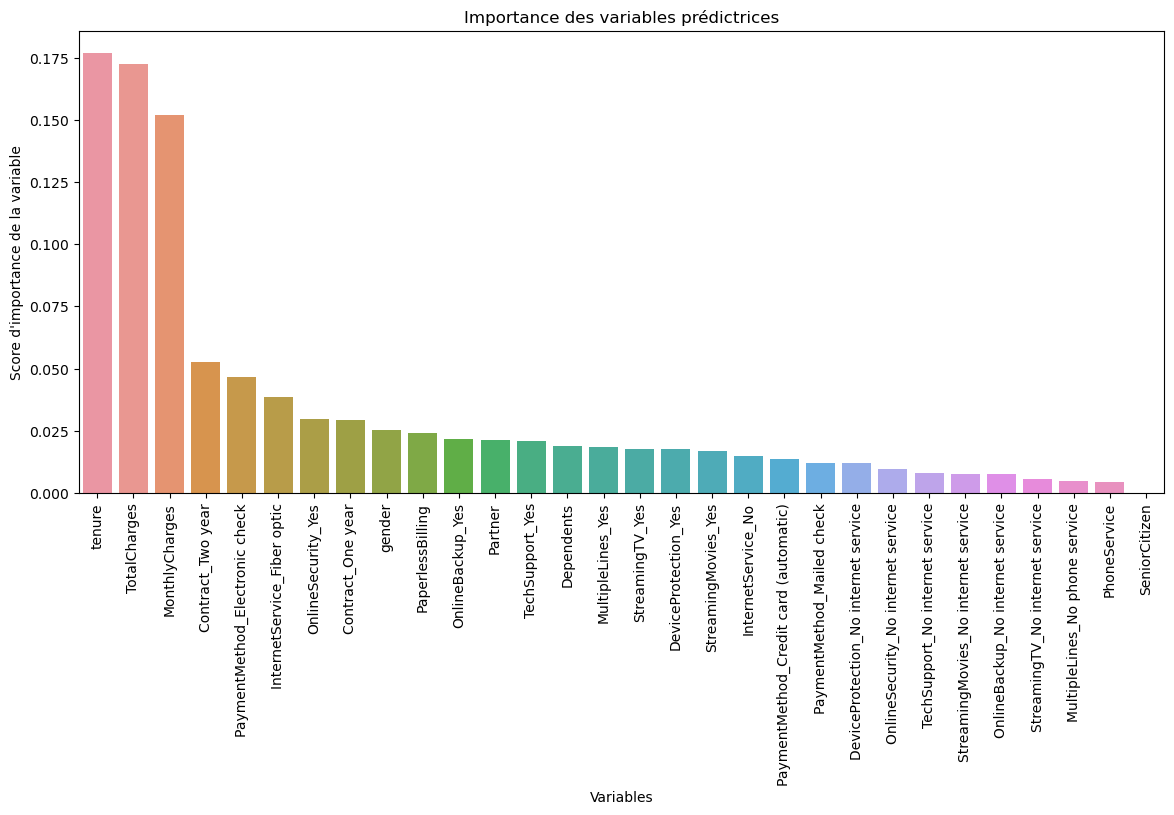

In [172]:
# Importances des variables indépendantes

plt.figure(figsize=(14, 6))

vars_imp = pd.Series(rf.feature_importances_, index = train_features.columns).sort_values(ascending=False)

sns.barplot(x = vars_imp.index, y=vars_imp)
plt.xticks(rotation=90)
plt.xlabel("Variables")
plt.ylabel("Score d'importance de la variable")
plt.title("Importance des variables prédictrices")
plt.show()

In [173]:
# Affichage de vars_imp

vars_imp

tenure                                   0.176995
TotalCharges                             0.172443
MonthlyCharges                           0.152120
Contract_Two year                        0.052477
PaymentMethod_Electronic check           0.046640
InternetService_Fiber optic              0.038614
OnlineSecurity_Yes                       0.029729
Contract_One year                        0.029450
gender                                   0.025294
PaperlessBilling                         0.024167
OnlineBackup_Yes                         0.021489
Partner                                  0.021064
TechSupport_Yes                          0.020977
Dependents                               0.018886
MultipleLines_Yes                        0.018498
StreamingTV_Yes                          0.017718
DeviceProtection_Yes                     0.017651
StreamingMovies_Yes                      0.016848
InternetService_No                       0.014628
PaymentMethod_Credit card (automatic)    0.013643


In [174]:
# Variables sélectionnées pour les algorithmes

seuil = 0.004


vars_selected = vars_imp[vars_imp > seuil].index.to_list()


train_features = train_features[vars_selected]

X_val = X_val[vars_selected]

X_test = X_test[vars_selected]


In [175]:
# Nombres de variables prédictrices

len(train_features.columns)

29

Notre objectif est de construire un modèle de classification qui prédit si un client va se désabonner ou non. Nous utiliserpns différents algorithmes(**Logistic Regression, Random Forest, Gradient Boosting, Classificateur Perceptron Multicouche et Support Vector Machine**) afin de comparer leurs performances et de choisir le meilleur modèle.

## Modèle de Régression logistique

In [176]:
# Dictionnaire des hyper paramètre

param_grid = {'C':[0.001, 0.01, 1, 10, 50, 100, 500]}

# Objet GridSearchCV

grid_logreg_class = GridSearchCV(estimator=LogisticRegression(random_state=seed, max_iter=500), 
                                 param_grid=param_grid, 
                                 scoring='f1', cv=5)



# Entraînement de l'algorithme

logreg_model = grid_logreg_class.fit(train_features, train_labels)


# Meilleur score et meilleur hyperparamètre

print(round(logreg_model.best_score_, 3))

print(logreg_model.best_estimator_)




0.787
LogisticRegression(C=50, max_iter=500, random_state=1111)


Le modèle a un bon score d'entraînement. Evaluons sa performance sur les données de validation afin d'apprécier sa capacité à généraliser sur de nouvelles données.

In [177]:
# Fonction d'évaluation de la performance d'un modèle

def model_evaluation(model, features, labels):
    pred = model.predict(features)
    print(classification_report(labels, pred))

In [178]:
# Evaluation du modèle de régression logistique

model_evaluation(logreg_model, X_val, y_val)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1032
           1       0.51      0.74      0.60       374

    accuracy                           0.74      1406
   macro avg       0.70      0.74      0.70      1406
weighted avg       0.79      0.74      0.75      1406



on va appliquer l'algorithme **Recursive Feature Eliminator** (RFE) sur le modèle afin de voir s'il garde les mêmes performances lorsqu'on réduit le nombre de prédicteurs. En effet, plus le modèle est complexe, plus il est difficile de l'interpréter.

In [179]:
# Création d'une fonction de construction d'un modèle avec utilisation de l'algorithme RFE

def  model_with_rfe(model):
    rfe_model = RFE(estimator=model, verbose=0)
    rfe_model.fit(train_features, train_labels)
    mask = rfe_model.support_
    reduced_X = train_features.loc[:, mask]
    print(reduced_X.columns)
    return rfe_model
    

In [180]:
# Logistique Regression RFE

rfe_logreg_model = model_with_rfe(logreg_model.best_estimator_)

rfe_logreg_model

Index(['TotalCharges', 'Contract_Two year', 'PaymentMethod_Electronic check',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes',
       'Contract_One year', 'PaperlessBilling', 'MultipleLines_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'InternetService_No',
       'DeviceProtection_No internet service',
       'StreamingTV_No internet service', 'MultipleLines_No phone service'],
      dtype='object')


RFE(estimator=LogisticRegression(C=50, max_iter=500, random_state=1111))

In [181]:
# Evaluation du modèle de régression logistique avec RFE

model_evaluation(rfe_logreg_model, X_val, y_val)


              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1032
           1       0.51      0.74      0.60       374

    accuracy                           0.74      1406
   macro avg       0.70      0.74      0.71      1406
weighted avg       0.79      0.74      0.75      1406



La RFE a réduit le nombre de prédicteurs de 28 à 14 et n'a pas amélioré la performance du modèle. 

Nous allons passé à l'algorithme de forêt aléatoire.

## Modèle de Forêt aléatoire

In [62]:
# Dictionnaire des hyperparamètres

param_grid_rf = {'n_estimators':[10, 50, 100, 500, 1000],
                 'max_depth':[3, 5, 10, 20, None]}


# Objet GridSearchCV

grid_rf_class = GridSearchCV(estimator=RandomForestClassifier(random_state=seed),
                            param_grid = param_grid_rf,
                            scoring='f1',
                            cv=5)

# Entraînement de l'algorithme

rf_model = grid_rf_class.fit(train_features, train_labels)


# Meilleur score et meilleur hyperparamètre

print(round(rf_model.best_score_, 3))

print(rf_model.best_estimator_)

0.906
RandomForestClassifier(max_depth=20, n_estimators=1000, random_state=1111)


In [63]:
# Evaluation du modèle de forêt aléatoire

model_evaluation(rf_model.best_estimator_, X_val, y_val)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1032
           1       0.55      0.52      0.54       374

    accuracy                           0.76      1406
   macro avg       0.69      0.68      0.69      1406
weighted avg       0.76      0.76      0.76      1406



Comparé aux valeurs du modèle de régression logistique, le modèle de forêt aléatoire semble moins efficace.

Nous allons appliquer une RFE.

In [64]:
# Random Forest avec RFE

rfe_forest_model = model_with_rfe(rf_model.best_estimator_)

rfe_forest_model

Index(['TotalCharges', 'tenure', 'MonthlyCharges', 'Contract_Two year',
       'PaymentMethod_Electronic check', 'InternetService_Fiber optic',
       'Contract_One year', 'OnlineSecurity_Yes', 'TechSupport_Yes',
       'PaperlessBilling', 'OnlineBackup_Yes', 'Partner', 'Dependents',
       'StreamingMovies_No internet service'],
      dtype='object')


RFE(estimator=RandomForestClassifier(max_depth=20, n_estimators=1000,
                                     random_state=1111))

In [65]:
# Evaluation du modèle de forêt aléatoire avec RFE

model_evaluation(rfe_forest_model, X_val, y_val)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1032
           1       0.56      0.54      0.55       374

    accuracy                           0.77      1406
   macro avg       0.70      0.69      0.70      1406
weighted avg       0.76      0.77      0.76      1406



Au regard de ces valeurs, nous allons retenir le modèle de forêt aléatoire obtenu sans RFE.

Nous allons passer à la construction d'un modèle de réseau de neuronnes artificiel.

## Classificateur Perceptron multicouche

In [66]:
# MLPClassifier

mlp = MLPClassifier(random_state=seed, max_iter=1000)

parameters = {'hidden_layer_sizes':[(50,), (100,), (200,)],
              'activation':['identity', 'logistic', 'tanh', 'relu'],
              'learning_rate':['constant', 'invscaling', 'adaptive']}


mlp_cv = GridSearchCV(mlp, parameters, scoring='f1', cv=5, n_jobs=-1)

mlp_cv.fit(train_features, train_labels)

/Users/abbasmzehamadi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/abbasmzehamadi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/abbasmzehamadi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/abbasmzehamadi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/abbasmzehamadi/anaconda3/lib/python3.11/site-packages/sklearn/neural_

/Users/abbasmzehamadi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/abbasmzehamadi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/abbasmzehamadi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/abbasmzehamadi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000, random_state=1111),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(50,), (100,), (200,)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='f1')

In [67]:
# Meilleur score et meilleur hyperparamètre

round(mlp_cv.best_score_, 3)

0.86

In [68]:
mlp_cv.best_estimator_

MLPClassifier(hidden_layer_sizes=(200,), max_iter=1000, random_state=1111)

In [69]:
# Evaluation du modèle Perceptron

model_evaluation(mlp_cv.best_estimator_, X_val, y_val)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1032
           1       0.56      0.56      0.56       374

    accuracy                           0.76      1406
   macro avg       0.70      0.70      0.70      1406
weighted avg       0.77      0.76      0.76      1406



## Support Vector Machine

In [70]:
# Support Vector Machine : Classifieur qui trouve l'hyperplan optimal qui maximise la frontière entre 2 classes

svm_model = SVC(random_state=seed)

svm_hyp = {'kernel':['linear', 'rbf'], 'C':[0.1, 1.0, 10, 50, 100]}

svm_cv = GridSearchCV(svm_model, svm_hyp, scoring='f1', cv=5)

svm_cv.fit(train_features, train_labels)

print(round(svm_cv.best_score_, 3))

print(svm_cv.best_estimator_)

0.847
SVC(C=100, random_state=1111)


In [71]:
# Evaluation du modèle SVM

model_evaluation(svm_cv.best_estimator_, X_val, y_val)

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1032
           1       0.48      0.58      0.52       374

    accuracy                           0.72      1406
   macro avg       0.66      0.67      0.66      1406
weighted avg       0.74      0.72      0.73      1406



## Conclusion

On a utilisé les données d'évaluation pour sélectionner le meilleur modèle. Ensuite nous évaluons le meilleur modèle sélectionné sur les données de test afin d'aprécier sa performance sur de nouvelles données. Idéalement les performances de ce modèle sur les données d'évaluation et sur les données de test doivent être relativement proches.

In [72]:
model_evaluation(logreg_model.best_estimator_, X_val, y_val)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1032
           1       0.51      0.74      0.60       374

    accuracy                           0.74      1406
   macro avg       0.70      0.74      0.71      1406
weighted avg       0.79      0.74      0.75      1406



In [73]:
# Performance du meilleur modèle sur les données de test

model_evaluation(logreg_model.best_estimator_, X_test, y_test)

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1033
           1       0.54      0.77      0.63       374

    accuracy                           0.77      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.77      0.78      1407



In [182]:
# Enregistrement du meilleur modèle

joblib.dump(logreg_model, "logreg_model.joblib")



['logreg_model.joblib']